# Project Header

In this project, we are looking at actigraphy data sourced from the [Depresjon](https://datasets.simula.no/depresjon/) dataset with the goal of developing a classification algorithm to aid in non-invasive recognition of those with a Major Depressive Disorder. The study included 32 healthy and 23 afflicted participants and collected activity data through participant's continual wearing of a watch containing an accelerometer. A record exists for each minute over 13 or more days where the activity associated with each minute is the sum of the number of movements with an acceleration greater than .5g. Related literature includes:

* Enrique Garcia-Ceja, Michael Riegler, Petter Jakobsen, Jim Tørresen, Tine Nordgreen, Ketil J. Oedegaard, and Ole Bernt Fasmer. 2018. Depresjon: a motor activity database of depression episodes in unipolar and bipolar patients. In Proceedings of the 9th ACM Multimedia Systems Conference (MMSys '18). Association for Computing Machinery, New York, NY, USA, 472–477. DOI:https://doi.org/10.1145/3204949.3208125

* Pacheco-Gonzalez, S.L., Zanella-Calzada, L.A., Galvan-Tejada, C.E., Chavez-Lamas, N.M., Rivera-Gomez, J.F., abnd Galvan-Tejada, J.I.. 2019. Evaluation of five classifiers for depression episodes detection, *Res. Comput. Sci.*, vol. 148, pp. 129-138.

* Rodríguez-Ruiz, J.G., Galván-Tejada, C.E., Vázquez-Reyes, S. et al. Classification of Depressive Episodes Using Nighttime Data; a Multivariate and Univariate Analysis. Program Comput Soft 46, 689–698 (2020). https://doi.org/10.1134/S0361768820080198

* Zanella-Calzada LA, Galván-Tejada CE, Chávez-Lamas NM, Gracia-Cortés MDC, Magallanes-Quintanar R, Celaya-Padilla JM, Galván-Tejada JI, Gamboa-Rosales H. Feature Extraction in Motor Activity Signal: Towards a Depression Episodes Detection in Unipolar and Bipolar Patients. Diagnostics (Basel). 2019 Jan 10;9(1):8. doi: https://10.3390/diagnostics9010008. PMID: 30634621; PMCID: PMC6468429.

# This Notebook

In this notebook we will be doing our initial exploration and pre-processing of the data. We hope to increase the ability of classification algorithms to make predictions through addition of features that quantify and qualify data as it is divided into time sections for patients.

## Importing Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

In [2]:
condition_list = glob("./data/condition/*.csv")
control_list = glob("./data/control/*.csv")
cleaned_conditions = [filename.split('\\')[1].replace('.csv', '')
                     for filename in condition_list]
cleaned_controls = [filename.split('\\')[1].replace('.csv', '')
                     for filename in control_list]

In [3]:
condition_dfs = {}
control_dfs = {}
for idx,file in enumerate(condition_list):
    condition_dfs.update({cleaned_conditions[idx]: pd.read_csv(file)})
for idx,file in enumerate(control_list):
    control_dfs.update({cleaned_controls[idx]: pd.read_csv(file)})

In [4]:
condition_dfs['condition_1'].head()

,timestamp,date,activity
0,2003-05-07 12:00:00,2003-05-07,0
1,2003-05-07 12:01:00,2003-05-07,143
2,2003-05-07 12:02:00,2003-05-07,0
3,2003-05-07 12:03:00,2003-05-07,20
4,2003-05-07 12:04:00,2003-05-07,166


In [5]:
condition_dfs['condition_1'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23244 entries, 0 to 23243
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  23244 non-null  object
 1   date       23244 non-null  object
 2   activity   23244 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 544.9+ KB


In [6]:
type(condition_dfs['condition_5'].iloc[0].timestamp)
test_stamp = pd.to_datetime(condition_dfs['condition_5'].iloc[0].timestamp)
print(test_stamp)
print(test_stamp.hour)

2003-06-12 10:30:00
10


Okay, so we can fix up these dataframes a little to start to make them easier to work with. Since we can cast the timestamp column into a datetime obj, we can get rid of the date column as it becomes redundant. So, let's recast timestamp and drop date for each dataframe.

In [7]:
for df in condition_dfs:
    condition_dfs[df] = condition_dfs[df].drop(columns = 'date')
    condition_dfs[df].timestamp = pd.to_datetime(condition_dfs[df].timestamp)

In [8]:
for df in control_dfs:
    control_dfs[df] = control_dfs[df].drop(columns = 'date')
    control_dfs[df].timestamp = pd.to_datetime(control_dfs[df].timestamp)

In [9]:
for patient in condition_dfs:
    print(condition_dfs[patient].shape[0]/60/24)

16.141666666666666
14.96875
15.965277777777779
15.379861111111111
17.993055555555554
15.031944444444443
15.159027777777778
29.06041666666667
14.952083333333334
14.824305555555556
14.74375
27.031944444444445
17.949305555555558
14.227083333333333
15.119444444444445
21.864583333333332
15.033333333333333
14.969444444444443
14.925694444444444
14.884027777777776
15.399305555555555
13.402083333333332
14.109722222222222


In [10]:
for patient in control_dfs:
    print(control_dfs[patient].shape[0]/60/24)

35.84097222222222
15.038194444444445
17.20277777777778
24.053472222222222
15.456249999999999
15.457638888888889
15.460416666666667
17.050694444444442
20.072916666666668
17.093055555555555
19.172916666666666
21.85625
22.146527777777777
22.177777777777777
15.06111111111111
15.065277777777778
15.155555555555557
15.151388888888889
23.17013888888889
14.229166666666666
17.038888888888888
16.96736111111111
45.421527777777776
15.047916666666666
35.68680555555556
35.84652777777778
21.84375
32.731249999999996
35.825694444444444
35.75694444444444
20.081944444444442
20.165277777777778


Hmm.. so the subjects did not wear the watches for a standard number of days. In fact, there is a pretty wide distribution in the amount of time the watch was worn, from a minimum near 13 days all the way up to a maximum in the control group for 45 days. I think the first thing I would like to do is determine how to efficiently establish sleeping vs not sleeping for each patient. I think in the future I will have to group the data into hour or half-hour lapses, based on the literature, so I will have to decide between making partial-hour cutoffs at hard sleep vs not sleep divisions, or decide on some metric in which the subject is primarily awake or asleep during pre-defined hour divisions.

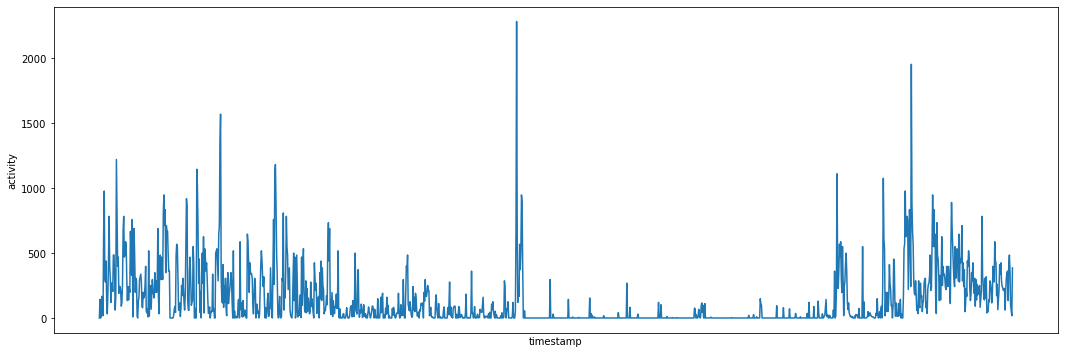

In [55]:
fig1, ax1 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condition_dfs['condition_1'].iloc[:1500], x = 'timestamp', y = 'activity');
ax1.axes.xaxis.set_ticks([]);

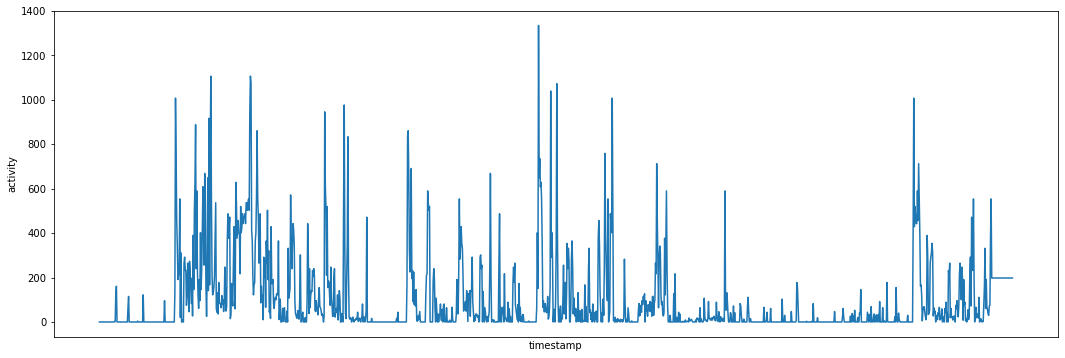

In [12]:
fig3, ax3 = plt.subplots(figsize = (18,6));
sns.lineplot(data = condition_dfs['condition_5'].iloc[:1500], x = 'timestamp', y = 'activity');
ax3.axes.xaxis.set_ticks([]);

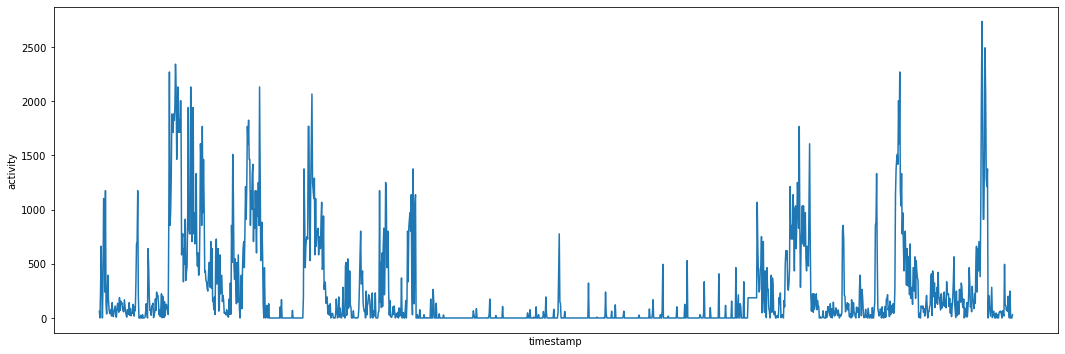

In [13]:
fig2, ax2 = plt.subplots(figsize = (18,6));
sns.lineplot(data = control_dfs['control_1'].iloc[:1500], x = 'timestamp', y = 'activity');
ax2.axes.xaxis.set_ticks([]);

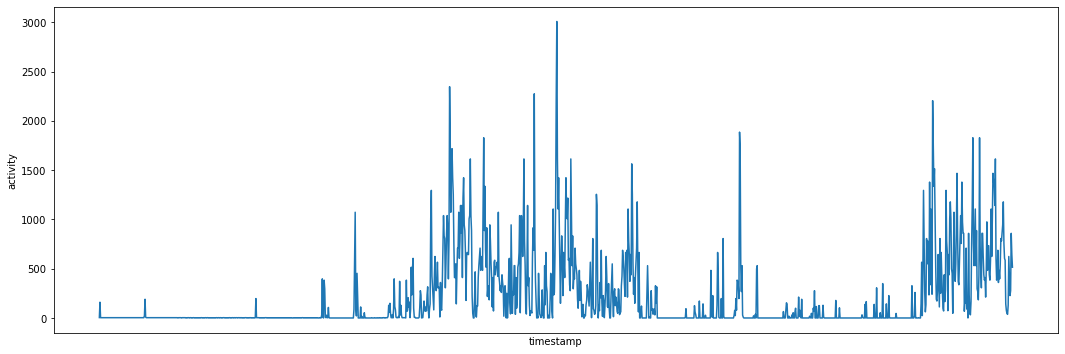

In [14]:
fig4, ax4 = plt.subplots(figsize = (18,6));
sns.lineplot(data = control_dfs['control_8'].iloc[:1500], x = 'timestamp', y = 'activity');
ax4.axes.xaxis.set_ticks([]);

In [22]:
condition_dfs['condition_1'].iloc[0]

timestamp    2003-05-07 12:00:00
activity                       0
Name: 0, dtype: object

In [16]:
control_dfs['control_1'].iloc[0]

timestamp    2003-03-18 15:00:00
activity                      60
Name: 0, dtype: object

In [25]:
condition_dfs['condition_1'].iloc[:60]

,timestamp,activity
0,2003-05-07 12:00:00,0
1,2003-05-07 12:01:00,143
2,2003-05-07 12:02:00,0
3,2003-05-07 12:03:00,20
4,2003-05-07 12:04:00,166
5,2003-05-07 12:05:00,160
6,2003-05-07 12:06:00,17
7,2003-05-07 12:07:00,646
8,2003-05-07 12:08:00,978
9,2003-05-07 12:09:00,306


In [130]:
peaks_arr = abs(np.fft.rfft(control_dfs['control_1'].activity))

In [131]:
peaks_arr

array([5086010.        , 3639372.54386245,  899976.14347068, ...,
         33785.42418533,   15237.61269766,   27318.9933849 ])

In [132]:
n = control_dfs['control_1'].activity.size
freq_arr = np.fft.rfftfreq(n, d = 1/60)

In [133]:
print(len(freq_arr))
print(n)

25806
51611


In [134]:
freq_arr

array([0.00000000e+00, 1.16254287e-03, 2.32508574e-03, ...,
       2.99970936e+01, 2.99982562e+01, 2.99994187e+01])

<AxesSubplot:>

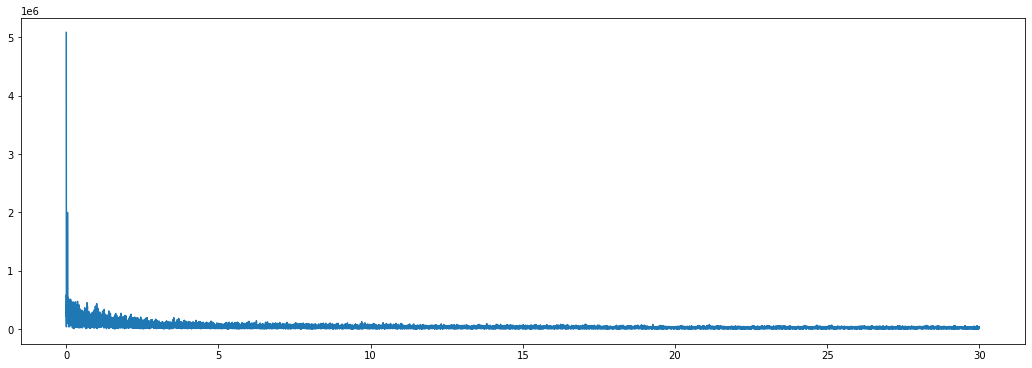

In [143]:
fig, ax = plt.subplots(figsize = (18,6))
sns.lineplot(y=peaks_arr,x=freq_arr)